In [210]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pymc3 as pm
import pandas as pd

%matplotlib inline

In [211]:
df = (pd.read_csv('./sintered_modulus.csv'))
df['mat_code'] = df['material'].map({'Fe': 0 , 'DiSA':1, 'ACrM':2})
df['Er']=df.E/212
df

,density,E,G,rho_r,porosity,Er,material,mat_code
0,6.814,135.5,54.40,0.867,0.133,0.639151,Fe,0
1,6.854,135.5,54.40,0.872,0.128,0.639151,Fe,0
2,6.828,135.5,54.80,0.869,0.131,0.639151,Fe,0
3,6.838,135.9,54.60,0.870,0.130,0.641038,Fe,0
4,6.847,137.4,54.70,0.871,0.129,0.648113,Fe,0
5,6.814,135.6,54.70,0.867,0.133,0.639623,Fe,0
6,6.963,146.2,58.80,0.886,0.114,0.689623,Fe,0
7,6.998,144.0,57.80,0.890,0.110,0.679245,Fe,0
8,6.993,146.6,58.90,0.890,0.110,0.691509,Fe,0
9,7.019,147.0,59.00,0.893,0.107,0.693396,Fe,0


In [186]:
raw_density =np.array([6.60, 6.73, 6.74,6.75,6.84, 6.89, 6.90, 6.88, 7.01,7.03]).reshape(-1,1)
E_modulus =np.array([135.502, 136.828,136.644,137.792,148.436,147.230,147.278,147.120,147.677,158.005]).reshape(-1,1)

porosity = df.loc[df.mat_code ==0 , 'porosity']
rel_modulus = df.loc[df.mat_code ==0 , 'Er']
mat_code=df.mat_code.values

In [187]:
# Test data
Xtrain=porosity # Relative porosity
Ytrain=rel_modulus
n=len(Xtrain)
n

18

In [5]:
Xdata = np.column_stack((Xtrain, Xtrain**2)) #Regressors matrix
Xdata.shape

(18, 2)

In [6]:
with pm.Model() as model:
          
    #Priors
    #E0 =pm.Normal('E0', mu=212, sd=10)
    b = pm.Normal('b', mu=1, sd=1, shape =1)
    sigma = pm.HalfCauchy('sigma', beta=10)
    pm.Deterministic('Pc',1/b)
    beta = [-b-1, b]
    
    Xshared=pm.Data('porosity', Xdata)

    #link function
    mu = 1 +pm.math.dot(Xshared, beta)

    #likelihood
    y = pm.Normal('y', mu =mu, sd= sigma, observed = Ytrain)
    
    trace=pm.sample(5000, random_seed=56421)

<ipython-input-6-3f0c5569bab8>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(5000, random_seed=56421)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 587 seconds.


In [8]:
#Posterior predictive
Xtest =np.linspace(0, 0.5 ,50)

with model:
    pm.set_data({'porosity': np.column_stack((Xtest, Xtest**2)) })
    y_test = pm.sample_posterior_predictive(trace)

In [9]:
import arviz as az

with model:   
    idata = az.from_pymc3(trace, posterior_predictive = y_test)

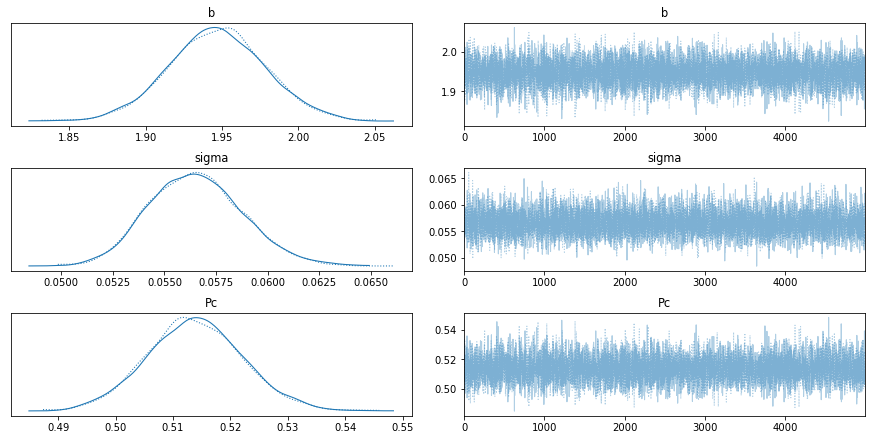

In [10]:
az.plot_trace(idata);

In [11]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],1.947,0.032,1.882,2.007,0.0,0.0,9478.0,6942.0,1.0
sigma,0.057,0.002,0.052,0.061,0.0,0.0,8813.0,6823.0,1.0
Pc[0],0.514,0.008,0.497,0.530,0.0,0.0,9478.0,6942.0,1.0


In [209]:
1-4/7.86


0.4910941475826972

In [190]:
import seaborn as sns

In [185]:
ppc_hdi = az.hdi(idata.posterior_predictive.y,  input_core_dims=[["chain", "draw", "y_dim_1"]])
ppc_hdi.y.shape

(50, 2)

In [176]:
b_trace = az.hdi(idata.posterior.b, input_core_dims=[["chain", 'draw']])
b_trace.b.values
np.column_stack([-b_trace.b.T-1, b_trace.b.T])
ym=1 +np.dot( np.column_stack((Xtest, Xtest**2)), np.column_stack([-b_trace.b.T-1, b_trace.b.T]).T)


array([[ 1.        ,  1.        ],
       [ 0.97075342,  0.96953825],
       [ 0.94189947,  0.93949419],
       [ 0.91343815,  0.90986781],
       [ 0.88536946,  0.88065912],
       [ 0.85769339,  0.8518681 ],
       [ 0.83040996,  0.82349478],
       [ 0.80351915,  0.79553913],
       [ 0.77702097,  0.76800117],
       [ 0.75091542,  0.7408809 ],
       [ 0.7252025 ,  0.7141783 ],
       [ 0.69988221,  0.6878934 ],
       [ 0.67495455,  0.66202617],
       [ 0.65041952,  0.63657663],
       [ 0.62627711,  0.61154477],
       [ 0.60252734,  0.5869306 ],
       [ 0.57917019,  0.56273411],
       [ 0.55620567,  0.5389553 ],
       [ 0.53363378,  0.51559418],
       [ 0.51145452,  0.49265074],
       [ 0.48966789,  0.47012499],
       [ 0.46827389,  0.44801692],
       [ 0.44727251,  0.42632653],
       [ 0.42666377,  0.40505383],
       [ 0.40644765,  0.38419881],
       [ 0.38662416,  0.36376148],
       [ 0.3671933 ,  0.34374182],
       [ 0.34815507,  0.32413986],
       [ 0.32950947,

abc

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


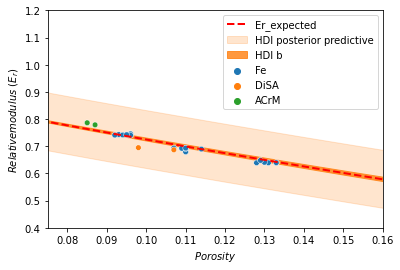

In [222]:

plt.plot(idata.constant_data.porosity.values[:,0], idata.posterior_predictive.y.mean(dim=("chain", "draw",'y_dim_1')), 'r--', lw=2,label='Er_expected')
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ppc_hdi.y.T, hdi_prob=0.95, fill_kwargs={"alpha": 0.2, 'label':'HDI posterior predictive'})
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ym.T,  fill_kwargs={"alpha": 0.8, 'label':'HDI b'} )
#plt.scatter(Xtrain, Ytrain,  label='data')
plt.xlabel('$Porosity$')
plt.ylabel('$Relative modulus$ ($E_r$)')
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'], marker='8')
plt.xlim([0.075,0.16])
plt.ylim(0.4,1.2)
plt.legend()

In [201]:
dfCr = (pd.read_csv('./DataAzadbeh.csv'))
dfCr['mat_code'] = dfCr['material'].map({'ACrL': 0 , 'ACrM':1})
dfCr['Er']=dfCr.E_Gpa/220


C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<AxesSubplot:xlabel='$Porosity$', ylabel='$Relative modulus$ ($E_r$)'>

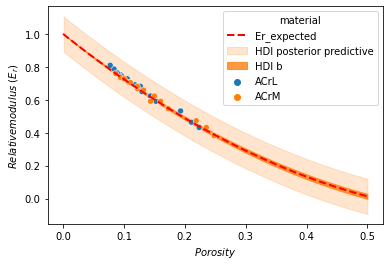

In [202]:
plt.plot(idata.constant_data.porosity.values[:,0], idata.posterior_predictive.y.mean(dim=("chain", "draw",'y_dim_1')), 'r--', lw=2,label='Er_expected')
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ppc_hdi.y.T, hdi_prob=0.95, fill_kwargs={"alpha": 0.2, 'label':'HDI posterior predictive'})
az.plot_hdi(idata.constant_data.porosity.values[:,0] , ym.T,  fill_kwargs={"alpha": 0.8, 'label':'HDI b'} )
#plt.scatter(Xtrain, Ytrain,  label='data')
plt.legend()
plt.xlabel('$Porosity$')
plt.ylabel('$Relative modulus$ ($E_r$)')
sns.scatterplot(x=dfCr['P'], y=dfCr['Er'], hue=dfCr['material'])

In [158]:
import seaborn as sns

<AxesSubplot:xlabel='porosity', ylabel='Er'>

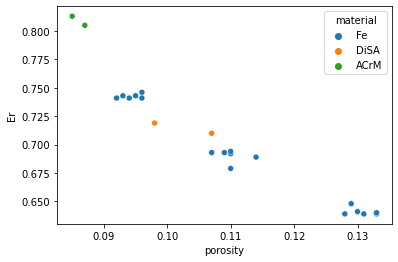

In [159]:
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'])

<AxesSubplot:xlabel='Relative porosity', ylabel='Relative E modulus (Er)'>

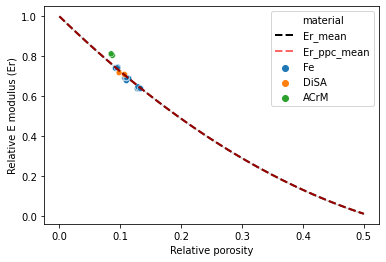

In [162]:
plt.plot(Xtest, Ytest_mean, 'k--', lw=2, label='Er_mean')
plt.gca().fill_between(Xtest.flat, yd2 , yd1, color ='#dddddd', alpha=1)
#plt.scatter(Xtrain_p,Ytrain, label='Er_data')
plt.plot(Xtest, yd.mean(axis=1), 'r--',lw=2, label="Er_ppc_mean", alpha=0.6)
plt.legend()
plt.xlabel('Relative porosity')
plt.ylabel('Relative E modulus (Er)')
sns.scatterplot(x=df['porosity'], y=df['Er'], hue=df['material'])
#plt.xlim([0, 0.2])
#plt.ylim([0.5,1])